In [42]:
import ot
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import random

### Movies Datasets

In [17]:
Movies = pd.read_csv('../DATASETS/ml-20m/movies.csv')

In [18]:
Movies.shape

(27278, 3)

In [20]:
Movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [21]:
Movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [30]:
Movies.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

### Ratings Datasets

In [22]:
ratings_data = pd.read_csv('../DATASETS/ml-20m/ratings.csv', sep=',')
ratings_data.shape

(20000263, 4)

In [23]:
ratings_data.describe()

,userId,movieId,rating,timestamp
count,2.000026e+07,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00,1.100918e+09
std,4.003863e+04,1.978948e+04,1.051989e+00,1.621694e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,3.439500e+04,9.020000e+02,3.000000e+00,9.667977e+08
50%,6.914100e+04,2.167000e+03,3.500000e+00,1.103556e+09
75%,1.036370e+05,4.770000e+03,4.000000e+00,1.225642e+09
max,1.384930e+05,1.312620e+05,5.000000e+00,1.427784e+09


In [24]:
ratings_data.shape

(20000263, 4)

In [29]:
ratings_data.isnull().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

### Tags Datasets

In [25]:
tags_data = pd.read_csv('../DATASETS/ml-20m/tags.csv', sep=',')

In [26]:
tags_data.shape

(465564, 4)

In [28]:
tags_data.isnull().any()

userId       False
movieId      False
tag           True
timestamp    False
dtype: bool

In [31]:
# drop null rows
tags_data = tags_data.dropna()

In [32]:
tags_data.isnull().any()

userId       False
movieId      False
tag          False
timestamp    False
dtype: bool

In [35]:
# number of unique tags
unique_tags = tags_data['tag'].unique().tolist()
len(unique_tags)

38643

In [41]:
Movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [38]:
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [40]:
tags_data.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


## Data visualization

In [44]:
#define a function that counts the number of times each genre appear:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [45]:
#here we  make census of the genres:
genre_labels = set()
for s in Movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [50]:
genre_labels

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [47]:
#counting how many times each of genres occur:
keyword_occurences, dum = count_word(Movies, 'genres', genre_labels)
keyword_occurences

[['Drama', 13344],
 ['Comedy', 8374],
 ['Thriller', 4178],
 ['Romance', 4127],
 ['Action', 3520],
 ['Crime', 2939],
 ['Horror', 2611],
 ['Documentary', 2471],
 ['Adventure', 2329],
 ['Sci-Fi', 1743],
 ['Mystery', 1514],
 ['Fantasy', 1412],
 ['War', 1194],
 ['Children', 1139],
 ['Musical', 1036],
 ['Animation', 1027],
 ['Western', 676],
 ['Film-Noir', 330],
 ['(no genres listed)', 246],
 ['IMAX', 196]]

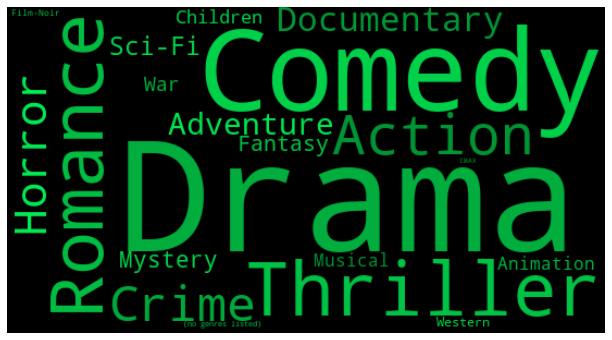

In [48]:
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

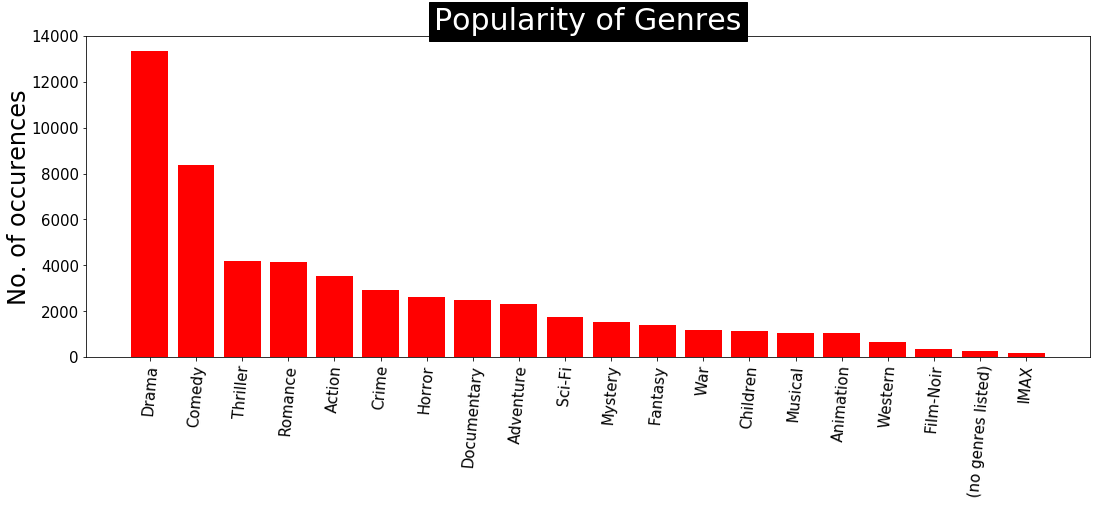

In [49]:
# lets display the same result in the histogram
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='r')
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

### Merging datasets

In [ ]:
Movies_ratings_data = Movies.merge(ratings_data, on = 'movieId', how='inner')

In [54]:
Movies_ratings_data.head(5)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,944919407
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,858275452
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,833981871
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,943497887
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,1230858821
